In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [3]:
model_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\model_vars_data_n.csv',index_col=0)

test_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\test_vars_data_n.csv',index_col=0)

price_train = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_train.csv',index_col=0)

price_test = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_test.csv',index_col=0)

In [4]:
# list(model_vars_data.columns) 
model_vars_data = model_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1)
test_vars_data = test_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1) 
#there is a transformed version of LotArea


In [5]:
# Fucntion returns dictionary

def regx3(
model=  None,
x_train = None,
x_test = None,
y_train = None,
y_test =  None,
params = None,
cv_ = 5,
linear_reg = True,
tree_based = False):
######################################
#########################################

    features = list(x_train.columns)

    ss = StandardScaler()
    x_train = pd.DataFrame(ss.fit_transform(x_train), columns = features)
    x_test = pd.DataFrame(ss.fit_transform(x_test), columns = features)

    #     print('train ',x_train.head())
    #     print(' ')
    #     print('test ', x_test.head())


    gs = GridSearchCV(model, params, cv=cv_, return_train_score=True, refit=True)
    gs.fit(x_train,y_train)
    gs.best_params_

    reg_dict = {}
    model= gs.best_estimator_
    reg_dict['mod'] = model
    ###################################    

    print('best params: ',gs.best_params_)
    reg_dict['best params'] = gs.best_params_

    print('score: ',gs.score(x_train,y_train))
    reg_dict['score'] = gs.score(x_train,y_train)

    print('  ')
    print('test score: ',gs.score(x_test,y_test))
    reg_dict['test score'] = gs.score(x_test,y_test)

    if linear_reg:
        adj_r2 = 1-(1-gs.score(x_train,y_train))*(x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        print('adj_r2: ', adj_r2)
        reg_dict['adj_r2'] = adj_r2

        adj_r2_test = 1-(1-gs.score(x_test,y_test))*(x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
        print('  ')
        print('adj_r2_test: ',adj_r2_test)
        reg_dict['adj_r2_test'] = adj_r2_test

        print(' ')

    train_pred = gs.best_estimator_.predict(x_train)
    print('train RMSE: ' + str(mean_squared_error(train_pred,y_train)**0.5))
    print('  ')
    reg_dict['train RMSE'] = mean_squared_error(train_pred,y_train)**0.5

    test_pred = gs.best_estimator_.predict(x_test)
    print('test RMSE: ' + str(mean_squared_error(test_pred,y_test)**0.5))
    ###
    reg_dict['test RMSE'] = mean_squared_error(test_pred,y_test)**0.5

    if linear_reg:

        coefs = pd.Series(gs.best_estimator_.coef_, name = 'coef' )

        varnames = pd.Series(features, name = 'features')

        pd.set_option('display.max_rows', None) # or 1000.

        abs_coefs = pd.Series(np.abs(coefs),name = 'abs_val')

        coefs_ = pd.concat([varnames,coefs, abs_coefs], axis=1)

        #return:
        model_importances = coefs_.sort_values(by=['abs_val'], ascending=False)
        model_importances.index=(range(model_importances.shape[0]))
        model_importances
        reg_dict['model_importances'] = model_importances

        print(model_importances)
        print(' ')

    elif tree_based:
        pd.set_option('display.max_rows', None) # or 1000.

        #return
        varnames = pd.Series(features, name = 'features')

        importances_ = pd.Series(model.feature_importances_, name = 'importances')

        df = pd.concat([varnames,importances_], axis=1)

        model_importances = df.sort_values(by=['importances'], ascending=False)

        model_importances.index=(range(model_importances.shape[0]))

        reg_dict['model_importances'] = model_importances



    #         model_importances = pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

        print(model_importances)


    if linear_reg:
        residuals = y_train - train_pred
        print('skewness: ',stats.skew(residuals))
        print(' ')
        sns.set_theme(style='darkgrid')
        sns.histplot(residuals, bins=20);

    print('model_importances.shape: ',model_importances.shape)
    
    return reg_dict


In [6]:
def to_keep(mod, amt):
    mod = mod['model_importances']
    keeps1 = mod.loc[mod['abs_val'] > amt,['features']]
    list_keeps1 = list(keeps1.features)
    return list_keeps1


remove due to mulicollinearity - see Correlations Analysis notebook

In [7]:
remove = ['log_first_FlrSF','BsmtFinSF1', 'BsmtUnfSF','yeo_GarageArea','GarageCars',
          'yeo_LotFrontage', 'BsmtFinSF2' ] #remove due to mulicollinearity #drop GarageYrBlt
#see Correlations Analysis notebook

In [8]:
keeps_set = set(model_vars_data.columns) - set(remove)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 0.01, 'l1_ratio': 0.5, 'tol': 0.1}
score:  0.9325723379337563
  
test score:  0.9202996016024988
adj_r2:  0.9240533660997394
  
adj_r2_test:  0.8920370489792714
 
train RMSE: 0.0980156868205935
  
test RMSE: 0.10521691891504273
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.142141  0.142141
1                                          OverallQual  0.079042  0.079042
2                                          GarageYrBlt  0.052978  0.052978
3                                      log_OpenPorchSF  0.043930  0.043930
4                                          OverallCond  0.041340  0.041340
5                                      yeo_TotalBsmtSF  0.039010  0.039010
6                                        has_openporch -0.036435  0.036435
7         Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.035461  0.035461
8                                           bc_LotArea  0.032794  0.03279

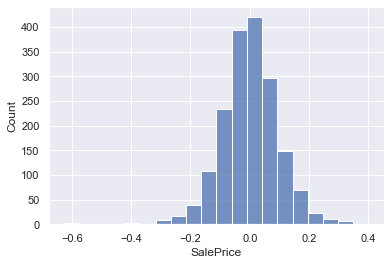

In [9]:
##### 'l1_ratio':[0,0.25,0.5,0.75,1]
elast1 = regx3(model= ElasticNet(max_iter=80000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.25,0.5,0.75,1],'tol':[0.1]},
cv_ = 5,
linear_reg = True,
tree_based = False)

<AxesSubplot:ylabel='Density'>

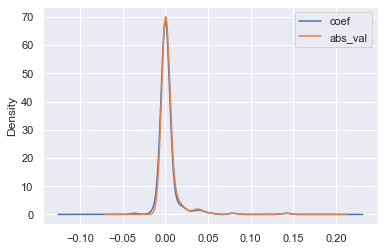

In [10]:
elast1['model_importances'].plot.kde() #0.03

<AxesSubplot:ylabel='Density'>

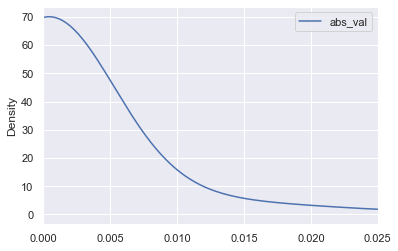

In [11]:
elast1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.025]) 

<AxesSubplot:ylabel='Density'>

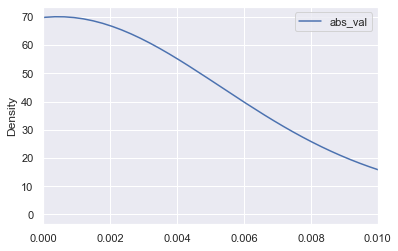

In [12]:
elast1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.010]) #drop > 0.003

<AxesSubplot:ylabel='Density'>

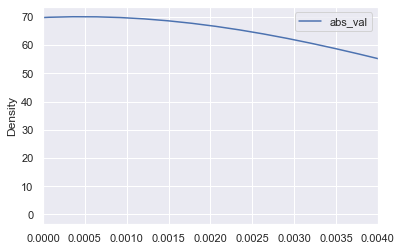

In [13]:
elast1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.004]) #0.0005

In [14]:

keeps = to_keep(elast1,0.0005)

In [15]:
# np.arange(0, 1, 0.01)

best params:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.1}
score:  0.9353377102890922
  
test score:  0.9220741179069171
adj_r2:  0.9333181824438701
  
adj_r2_test:  0.9161473606773023
 
train RMSE: 0.09598471422842911
  
test RMSE: 0.10403900677767612
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.140164  0.140164
1                                    OverallQual  0.084574  0.084574
2                                    GarageYrBlt  0.053426  0.053426
3                                yeo_TotalBsmtSF  0.045600  0.045600
4                                    OverallCond  0.040474  0.040474
5                                     bc_LotArea  0.038573  0.038573
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.034666  0.034666
7                                     Fireplaces  0.024558  0.024558
8                                    KitchenQual  0.021099  0.021099
9                                   BsmtFullBath  0.02069

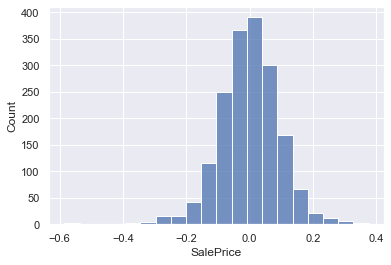

In [16]:
elast2 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [17]:
keeps = to_keep(elast2,0.00003,)

best params:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.1}
score:  0.9358528066669153
  
test score:  0.922610140279871
adj_r2:  0.9340020509446681
  
adj_r2_test:  0.9171906823162765
 
train RMSE: 0.09560164524933214
  
test RMSE: 0.10368056703067009
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.140394  0.140394
1                                    OverallQual  0.083917  0.083917
2                                    GarageYrBlt  0.049774  0.049774
3                                yeo_TotalBsmtSF  0.046092  0.046092
4                                     bc_LotArea  0.043554  0.043554
5                                    OverallCond  0.041795  0.041795
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.035005  0.035005
7                                     Fireplaces  0.025777  0.025777
8                                     house_age_ -0.024803  0.024803
9                                    KitchenQual  0.022535

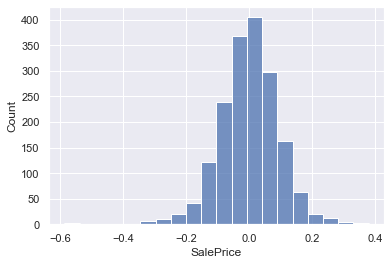

In [18]:
elast3 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [19]:
keeps = to_keep(elast3,0.0001)

best params:  {'alpha': 0.01, 'l1_ratio': 0.25, 'tol': 0.1}
score:  0.9356136973826609
  
test score:  0.924760796403958
adj_r2:  0.9337942459246161
  
adj_r2_test:  0.9196045432903831
 
train RMSE: 0.09577965754715388
  
test RMSE: 0.102229780646121
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.136043  0.136043
1                                    OverallQual  0.083314  0.083314
2                                yeo_TotalBsmtSF  0.049244  0.049244
3                                     bc_LotArea  0.045430  0.045430
4                                    OverallCond  0.044848  0.044848
5                                     house_age_ -0.042945  0.042945
6                                    GarageYrBlt  0.040338  0.040338
7   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.032789  0.032789
8                                     Fireplaces  0.026632  0.026632
9                                   BsmtFullBath  0.020114 

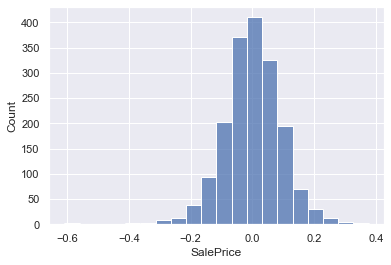

In [20]:
elast4 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [21]:
keeps = to_keep(elast4,0.0003)

best params:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.1}
score:  0.9352822948245355
  
test score:  0.9242698062236049
adj_r2:  0.9336066350242502
  
adj_r2_test:  0.9195300861680586
 
train RMSE: 0.09602583478292677
  
test RMSE: 0.10256279983299427
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.154290  0.154290
1                                    OverallQual  0.090986  0.090986
2                                     house_age_ -0.078574  0.078574
3                                    OverallCond  0.053237  0.053237
4                                     bc_LotArea  0.046700  0.046700
5                                yeo_TotalBsmtSF  0.046522  0.046522
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.028988  0.028988
7                                   BsmtFullBath  0.024426  0.024426
8                                     Fireplaces  0.020597  0.020597
9                                    GarageYrBlt  0.01739

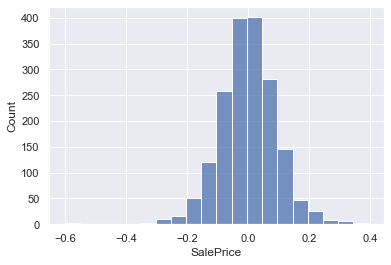

In [22]:
elast5 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [23]:
features5 = to_keep(elast5,0)
dummies=[]
for f in features5:
    if model_vars_data[f].max() == 1:
        dummies.append(f)


dummy_drops = []
for feature in dummies:
    if round(model_vars_data[feature].mean(),2) < 0.05:
        dummy_drops.append(feature)
dummy_drops

['SaleCondition_Family',
 'Exterior1st_BrkFace',
 'MSSubClass_85',
 'MSSubClass_160',
 'LandContour_HLS',
 'Condition1_PosN',
 'Exterior1st_PreCast',
 'SaleCondition_Partial',
 'Condition2_Feedr',
 'BldgType_Twnhs',
 'Condition1_PosA',
 'PavedDrive_P',
 'MSSubClass_190']

In [24]:
#remove dummies with less than 5% coverage to reduce noise

In [25]:
keep_set = set(features5) - set(dummy_drops)
keeps = list(keep_set)

best params:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.1}
score:  0.9298420027720047
  
test score:  0.9214132959092535
adj_r2:  0.9285598463406536
  
adj_r2_test:  0.9179778115774175
 
train RMSE: 0.09998045944356358
  
test RMSE: 0.10447920791628212
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.144570  0.144570
1                                    OverallQual  0.083196  0.083196
2                                     house_age_ -0.065489  0.065489
3                                yeo_TotalBsmtSF  0.046779  0.046779
4                                    OverallCond  0.046113  0.046113
5                                     bc_LotArea  0.044185  0.044185
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.036255  0.036255
7                                    KitchenQual  0.032054  0.032054
8                                   BsmtFullBath  0.024525  0.024525
9                    Neighborhood_Somerst_Timber  0.02099

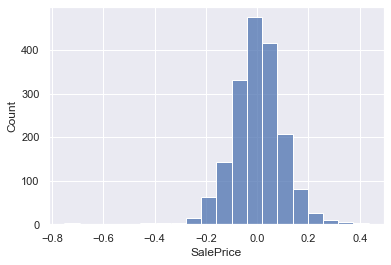

In [26]:
elast6 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [27]:
keeps = to_keep(elast6,0.0003)

best params:  {'alpha': 0.01, 'l1_ratio': 0.25, 'tol': 0.1}
score:  0.9286937560249676
  
test score:  0.9223429626483216
adj_r2:  0.9273906150728254
  
adj_r2_test:  0.9189481194854067
 
train RMSE: 0.1007953081906239
  
test RMSE: 0.10385938413315637
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.150567  0.150567
1                                    OverallQual  0.091038  0.091038
2                                     house_age_ -0.085952  0.085952
3                                     bc_LotArea  0.051286  0.051286
4                                    OverallCond  0.050899  0.050899
5                                yeo_TotalBsmtSF  0.046395  0.046395
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027416  0.027416
7                                   BsmtFullBath  0.020309  0.020309
8                                    KitchenQual  0.019235  0.019235
9                                     Fireplaces  0.01916

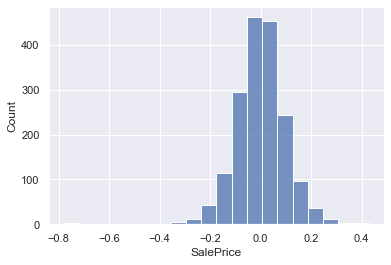

In [28]:
elast7 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [29]:
keeps = to_keep(elast7,0) #change hyperparameter for l1_ratio

best params:  {'alpha': 0.01, 'l1_ratio': 0.25, 'tol': 0.1}
score:  0.9284000524944964
  
test score:  0.9220213802917122
adj_r2:  0.9271331584461684
  
adj_r2_test:  0.9187235123367914
 
train RMSE: 0.10100267794466587
  
test RMSE: 0.10407420587300364
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.150458  0.150458
1                                    OverallQual  0.092751  0.092751
2                                     house_age_ -0.087086  0.087086
3                                     bc_LotArea  0.053852  0.053852
4                                    OverallCond  0.049620  0.049620
5                                yeo_TotalBsmtSF  0.044170  0.044170
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.025725  0.025725
7                                   BsmtFullBath  0.023024  0.023024
8                                     Fireplaces  0.019290  0.019290
9                                    KitchenQual  0.0189

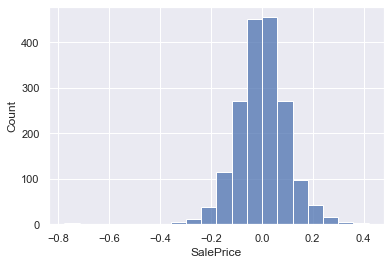

In [30]:
elast8 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.001,0.01,0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [31]:
keeps = to_keep(elast8, 0.008)

best params:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.1}
score:  0.9266251649454196
  
test score:  0.9203912244466926
adj_r2:  0.925750663506063
  
adj_r2_test:  0.9181411783005022
 
train RMSE: 0.10224688965881329
  
test RMSE: 0.10515642332312446
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.143924  0.143924
1                                    OverallQual  0.091279  0.091279
2                                     house_age_ -0.090928  0.090928
3                                     bc_LotArea  0.060146  0.060146
4                                    OverallCond  0.055110  0.055110
5                                yeo_TotalBsmtSF  0.052578  0.052578
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027540  0.027540
7                                     Fireplaces  0.022702  0.022702
8                                   BsmtFullBath  0.022270  0.022270
9                                      HeatingQC  0.016382

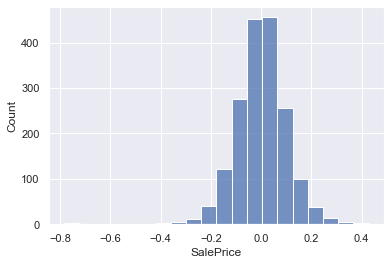

In [32]:
elast9 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.001,0.01,0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [33]:
keeps = to_keep(elast9, 0.01) 

best params:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.1}
score:  0.923757486173079
  
test score:  0.9149312213128056
adj_r2:  0.9229799421227194
  
adj_r2_test:  0.9128786234356346
 
train RMSE: 0.10422577671878976
  
test RMSE: 0.10870272539817942
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.138976  0.138976
1                                    OverallQual  0.094401  0.094401
2                                     house_age_ -0.093671  0.093671
3                                     bc_LotArea  0.061505  0.061505
4                                    OverallCond  0.057526  0.057526
5                                yeo_TotalBsmtSF  0.054990  0.054990
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027731  0.027731
7                                     Fireplaces  0.026685  0.026685
8                                   BsmtFullBath  0.024546  0.024546
9                                      HeatingQC  0.021932

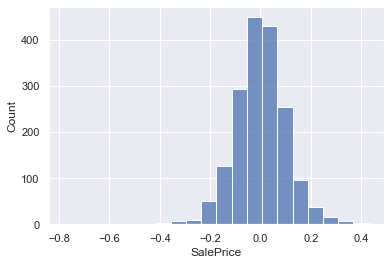

In [34]:
elast10 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.001,0.01,0.1,0.25,0.5,0.75,1],'tol':[0.1]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [11]:
#COPY BEST MODEL elast7 and lower tolerance to see if get lower RMSE

# keeps = to_keep(elast7,0) #change hyperparameter for l1_ratio from #7 #change tol

keeps_11 =['bc_GrLivArea',
 'OverallQual',
 'house_age_',
 'bc_LotArea',
 'OverallCond',
 'yeo_TotalBsmtSF',
 'Neighborhood_NoRidge_NridgHt_Veenker_StoneBr',
 'BsmtFullBath',
 'KitchenQual',
 'Fireplaces',
 'HeatingQC',
 'Functional',
 'Neighborhood_Somerst_Timber',
 'BedroomAbvGr',
 'GarageCond',
 'BsmtExposure',
 'Neighborhood_ClearCr_CollgCr_Crawfor',
 'Condition1_Norm',
 'BsmtFinType1',
 'MSZoning_RM',
 'ScreenPorch',
 'KitchenAbvGr',
 'GarageFinish_RFn',
 'CentralAir_Y',
 'MSSubClass_20',
 'BsmtHalfBath',
 'MoSold_7',
 'Neighborhood_Mitchel_NPkVill',
 'GarageYrBlt',
 'LowQualFinSF',
 'LandSlope']





# best model elast 11

best params:  {'alpha': 0.01, 'l1_ratio': 0.001, 'tol': 0.02}
score:  0.9321012285652457
  
test score:  0.9242924505262095
adj_r2:  0.9308998233629184
  
adj_r2_test:  0.9210906305621065
 
train RMSE: 0.09835750300298263
  
test RMSE: 0.10254746488799335
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.151078  0.151078
1                                    OverallQual  0.073532  0.073532
2                                     house_age_ -0.051836  0.051836
3                                    OverallCond  0.049366  0.049366
4                                     bc_LotArea  0.045503  0.045503
5                                yeo_TotalBsmtSF  0.041228  0.041228
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.035099  0.035099
7                                     Fireplaces  0.023315  0.023315
8                                    KitchenQual  0.023251  0.023251
9                                   BsmtFullBath  0.02

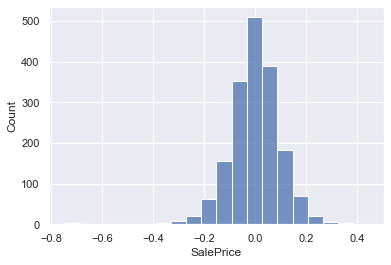

In [36]:
elast11 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.001,0.01,0.1,0.25,0.5,0.75,1],'tol':[0.02]},cv_ = 5,
linear_reg = True,
tree_based = False)

In [37]:
features = list(model_vars_data[keeps].columns)
ss = StandardScaler()

x_train = pd.DataFrame(ss.fit_transform(model_vars_data[keeps]), columns = features)
x_test = pd.DataFrame(ss.fit_transform(test_vars_data[keeps]), columns = features)


Calcualte average price difference for test data and train data

In [95]:
import math

predict_train = elast11['mod'].predict(x_train).reshape((-1,1)) # -1 however many rows it takes; 1 means 1 column
predict_test = elast11['mod'].predict(x_test).reshape((-1,1))


predicted_price_test = pd.Series(list(map(math.exp,predict_test)), name = 'predicted_price_test')
predicted_price_train = pd.Series(list(map(math.exp,predict_train)), name = 'predicted_price_train')


In [96]:
price_compare_test = pd.concat([predicted_price_test,price_test.reset_index()], axis=1)

price_compare_test['price_difference'] =   price_compare_test['SalePrice'] - price_compare_test['predicted_price_test']


average difference test data

In [97]:

price_compare_test.price_difference.abs().mean()

13315.455763826081

In [99]:
price_compare_train = pd.concat([predicted_price_train,price_train.reset_index()], axis=1)

price_compare_train['price_difference'] =   price_compare_train['SalePrice'] - price_compare_train['predicted_price_train']


average difference train data

In [100]:
price_compare_train.price_difference.abs().mean()

13080.411919418215

best params:  {'alpha': 0.01, 'l1_ratio': 0.001, 'tol': 0.02}
score:  0.9321012285652457
  
test score:  0.9242924505262095
adj_r2:  0.9308998233629184
  
adj_r2_test:  0.9210906305621065
 
train RMSE: 0.09835750300298263
  
test RMSE: 0.10254746488799335
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.151078  0.151078
1                                    OverallQual  0.073532  0.073532
2                                     house_age_ -0.051836  0.051836
3                                    OverallCond  0.049366  0.049366
4                                     bc_LotArea  0.045503  0.045503
5                                yeo_TotalBsmtSF  0.041228  0.041228
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.035099  0.035099
7                                     Fireplaces  0.023315  0.023315
8                                    KitchenQual  0.023251  0.023251
9                                   BsmtFullBath  0.02

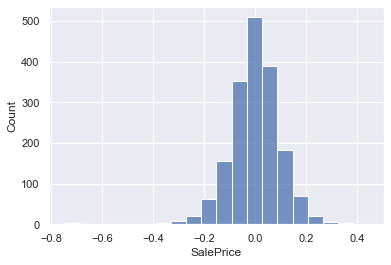

In [12]:
elast11 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps_11],
x_test = test_vars_data[keeps_11.
                       ],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],'l1_ratio':[0.001,0.01,0.1,0.25,0.5,0.75,1],'tol':[0.02]},cv_ = 5,
linear_reg = True,
tree_based = False)